# Regression Model For Predicting Movie Box Office Gross

Group Members: Ying Wu (A20370189), Yingjuan Wu (A20326320), Sahand Zeinali (A20318383)

Project Description: 
In this project, we will explore the relationship between a movie’s theatrical revenue and other key features. We will use worldwide box-office gross (numerical) as the target variable, and use relevant information that are available prior a movie's release as input variables, including general information like number of critic reviews, duration of movie (in mins), face number in poster, genres, budget, country, content-rating, imdb score, as well as social media factors like number of director facebook likes, number of cast total facebook likes, etc. 

The objective of this project is to build a regression model to predict movie box office gross. Categorical input variables include genres, country, and content-rating; numerical input variables are number of critic reviews, duration, face number in poster, budget, imdb score, number of director facebook likes, and number of cast total facebook likes. 

In [25]:
%matplotlib inline

import numpy as np 
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt

#import file, remove duplicate movies
movies = pd.read_csv("movie_metadata.csv", header = 0)
original_headers = list(movies.columns.values)#save headers in a list
movies = movies.drop_duplicates(['movie_title'])
movies.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [26]:
#select relevant features
movies = movies[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'genres', 'cast_total_facebook_likes', 'facenumber_in_poster', 'country', 'content_rating', 'budget', 'title_year', 'imdb_score']]
movies.head()

,num_critic_for_reviews,duration,director_facebook_likes,gross,genres,cast_total_facebook_likes,facenumber_in_poster,country,content_rating,budget,title_year,imdb_score
0,723.0,178.0,0.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,4834,0.0,USA,PG-13,237000000.0,2009.0,7.9
1,302.0,169.0,563.0,309404152.0,Action|Adventure|Fantasy,48350,0.0,USA,PG-13,300000000.0,2007.0,7.1
2,602.0,148.0,0.0,200074175.0,Action|Adventure|Thriller,11700,1.0,UK,PG-13,245000000.0,2015.0,6.8
3,813.0,164.0,22000.0,448130642.0,Action|Thriller,106759,0.0,USA,PG-13,250000000.0,2012.0,8.5
4,NaN,NaN,131.0,NaN,Documentary,143,0.0,NaN,NaN,NaN,NaN,7.1


In [27]:
#Data processing starts

#Remove movies that do not have box office gross
movies = movies[movies['gross'] > 0]

#Select movies produced in the past 50 years
movies = movies[movies['title_year'] >= 1966]

#Remove movies that do not have director_facebook_likes 
movies = movies[movies['director_facebook_likes'] > 0]

#Remove variable 'title_year', since it is not a predictor variable
movies = movies[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'genres', 'cast_total_facebook_likes', 'facenumber_in_poster', 'country', 'content_rating', 'budget', 'imdb_score']]

#print data shape
movies.shape

(3321, 11)

In [28]:
#Check the number of missing values in all features

print(movies['genres'].isnull().sum(),                       #check number of missing values in 'genres'
      movies['country'].isnull().sum(),                      #check number of missing values in 'country'
      movies['num_critic_for_reviews'].isnull().sum(),       #check number of missing values in 'num_critic_for_reviews'
      movies['duration'].isnull().sum(),                     #check number of missing values in 'duration'
      movies['cast_total_facebook_likes'].isnull().sum(),    #check number of missing values in 'cast_total_facebook_likes'
      movies['facenumber_in_poster'].isnull().sum(),         #check number of missing values in 'facenumber_in_poster'
      movies['budget'].isnull().sum(),                       #check number of missing values in 'budget'
      movies['imdb_score'].isnull().sum(),)                  #check number of missing values in 'imdb_score'

0 0 1 1 0 5 223 0


In [29]:
#Replace the missing values with the mean of that feature

#impute num_critic_for_reviews missing values with mean
movies['num_critic_for_reviews'] = movies['num_critic_for_reviews'].fillna(movies['num_critic_for_reviews'].mean())

#impute duration missing values with mean
movies['duration'] = movies['duration'].fillna(movies['duration'].mean())

#impute facenumber_in_poster missing values with mean
movies['facenumber_in_poster'] = movies['facenumber_in_poster'].fillna(movies['facenumber_in_poster'].mean())

#impute budget missing values with mean
movies['budget'] = movies['budget'].fillna(movies['budget'].mean())

In [30]:
#Binarize Genres feature

#First, find out all categories
genresList = movies['genres'].str.split('|')
genresArray = np.asarray(genresList)
oneArray = sum(genresArray, [])
genres = np.unique(oneArray)

#Second, add new binary features
i=0 
while i<len(genres): 
    movies[genres[i]]=movies['genres'].str.contains(genres[i]).astype(int)
    i=i+1

#Visualization
movies.head()




,num_critic_for_reviews,duration,director_facebook_likes,gross,genres,cast_total_facebook_likes,facenumber_in_poster,country,content_rating,budget,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,302.0,169.0,563.0,309404152.0,Action|Adventure|Fantasy,48350,0.0,USA,PG-13,300000000.0,...,0,0,0,0,0,0,0,0,0,0
3,813.0,164.0,22000.0,448130642.0,Action|Thriller,106759,0.0,USA,PG-13,250000000.0,...,0,0,0,0,0,0,0,1,0,0
5,462.0,132.0,475.0,73058679.0,Action|Adventure|Sci-Fi,1873,1.0,USA,PG-13,263700000.0,...,0,0,0,0,1,0,0,0,0,0
7,324.0,100.0,15.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,2036,1.0,USA,PG,260000000.0,...,1,0,0,1,0,0,0,0,0,0
9,375.0,153.0,282.0,301956980.0,Adventure|Family|Fantasy|Mystery,58753,3.0,UK,PG,250000000.0,...,0,1,0,0,0,0,0,0,0,0


In [31]:
#Binarize Countries and Content-rating 

#Country
countries = movies['country'].unique()
i=0
while i<len(countries):
    movies[countries[i]]=movies['country'].str.contains(countries[i]).astype(int)
    i=i+1

    
#Content-rating
#Replace empty cells or 'Unrated' with 'Not Rated' since they mean the same thing
movies['content_rating'] = movies['content_rating'].replace(np.nan,'Not Rated', regex=True)
movies['content_rating'] = movies['content_rating'].replace('Unrated','Not Rated', regex=True)

rating = movies['content_rating'].unique()
i=0
while i<len(rating):
    movies[rating[i]]=movies['content_rating'].str.match(rating[i]).astype(int)
    i=i+1

movies.head()


,num_critic_for_reviews,duration,director_facebook_likes,gross,genres,cast_total_facebook_likes,facenumber_in_poster,country,content_rating,budget,...,PG-13,PG,G,R,Not Rated,NC-17,Approved,M,GP,X
1,302.0,169.0,563.0,309404152.0,Action|Adventure|Fantasy,48350,0.0,USA,PG-13,300000000.0,...,1,1,0,0,0,0,0,0,0,0
3,813.0,164.0,22000.0,448130642.0,Action|Thriller,106759,0.0,USA,PG-13,250000000.0,...,1,1,0,0,0,0,0,0,0,0
5,462.0,132.0,475.0,73058679.0,Action|Adventure|Sci-Fi,1873,1.0,USA,PG-13,263700000.0,...,1,1,0,0,0,0,0,0,0,0
7,324.0,100.0,15.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,2036,1.0,USA,PG,260000000.0,...,0,1,0,0,0,0,0,0,0,0
9,375.0,153.0,282.0,301956980.0,Adventure|Family|Fantasy|Mystery,58753,3.0,UK,PG,250000000.0,...,0,1,0,0,0,0,0,0,0,0


In [32]:
#Data Processing is done, now prepare data for visualization and sklearn

#remove non-numeric columns
movies = movies._get_numeric_data() 

#put the numeric column names in a python list
numeric_headers = list(movies.columns.values) 

#create a numpy array with the numeric values for input into scikit-learn
movies_array = movies.as_matrix()

#Visualize
print(movies_array)

[[  3.02000000e+02   1.69000000e+02   5.63000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  8.13000000e+02   1.64000000e+02   2.20000000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.62000000e+02   1.32000000e+02   4.75000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  7.80000000e+01   1.11000000e+02   6.20000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.43000000e+02   7.70000000e+01   2.91000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.30000000e+01   9.00000000e+01   1.60000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [33]:
#Test if data can be used by scikit learn models

#select target variable as y, select input variables as x
y = movies_array[:, 3]
x = movies_array[:, list(range(0,3))+list(range(4,len(movies_array[0])))]

reg = linear_model.LinearRegression()
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

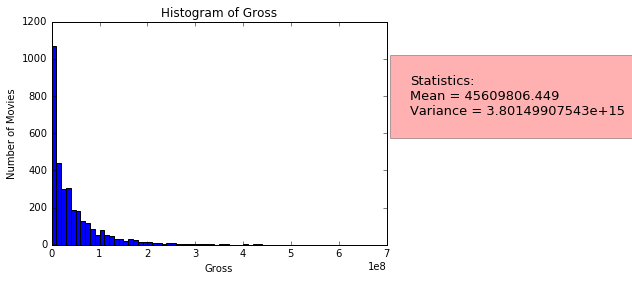

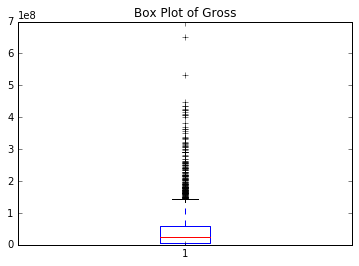

In [34]:
#Viusalization of target

#histogram of target
fig=plt.figure(1)
plt.hist(y, bins=np.arange(min(y),max(y),10000000))
plt.title('Histogram of Gross')
plt.xlabel('Gross')
plt.ylabel('Number of Movies')
fig.add_subplot(111).text(750000000, 700, 'Statistics:\n'+'Mean = %s'%np.mean(y) +'\nVariance = %s'%np.var(y),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#box plot of target
plt.figure(2)
plt.boxplot(y)
plt.title('Box Plot of Gross')
plt.show()

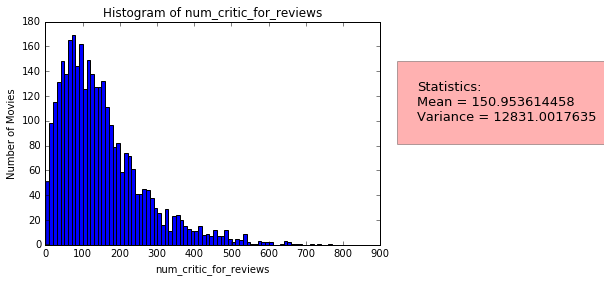

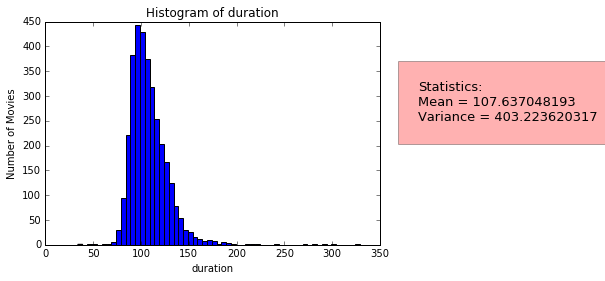

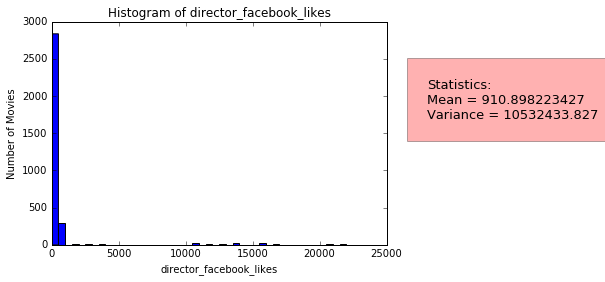

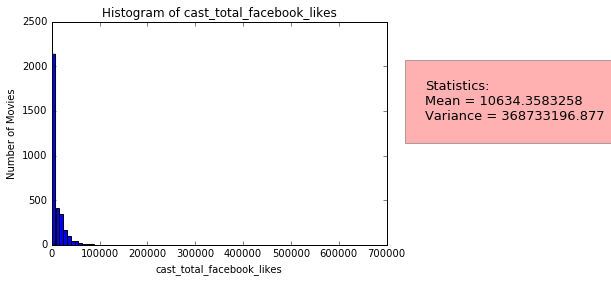

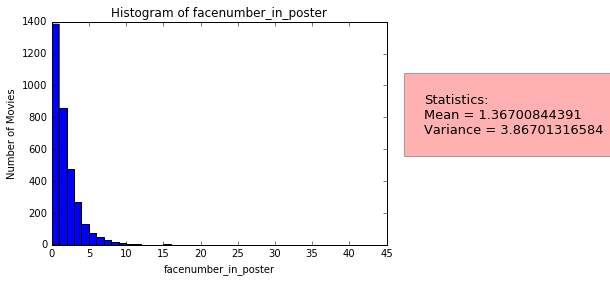

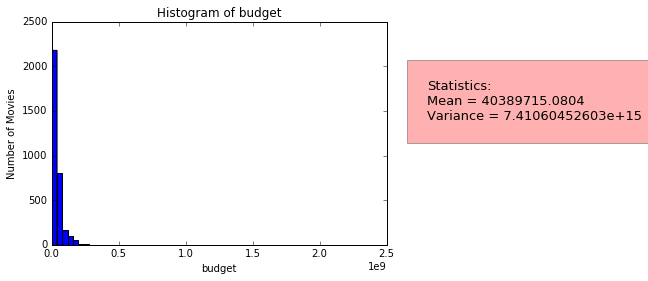

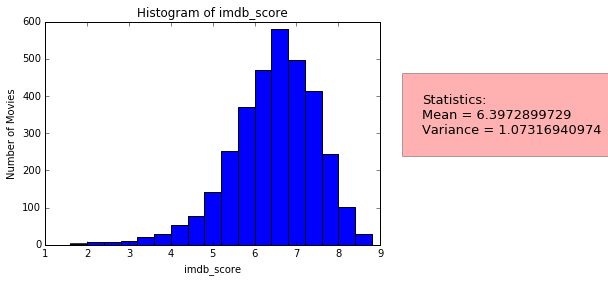

In [35]:
#Viusalization of all numerical features

#num_critic_for_reviews
fig1 = plt.figure(1)
NumOfReview = movies_array[:, 0]
plt.hist(NumOfReview, bins=np.arange(min(NumOfReview),max(NumOfReview),10))
plt.title('Histogram of num_critic_for_reviews')
plt.xlabel('num_critic_for_reviews')
plt.ylabel('Number of Movies')
fig1.add_subplot(111).text(1000, 100, 'Statistics:\n'+'Mean = %s'%np.mean(NumOfReview) +'\nVariance = %s'%np.var(NumOfReview),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#num_critic_for_reviews
fig2 = plt.figure(2)
duration = movies_array[:, 1]
plt.hist(duration, bins=np.arange(min(duration),max(duration),5))
plt.title('Histogram of duration')
plt.xlabel('duration')
plt.ylabel('Number of Movies')
fig2.add_subplot(111).text(390, 250, 'Statistics:\n'+'Mean = %s'%np.mean(duration) +'\nVariance = %s'%np.var(duration),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#director_facebook_likes
fig3 = plt.figure(3)
directorFB = movies_array[:, 2]
plt.hist(directorFB, bins=np.arange(min(directorFB),max(directorFB),500))
plt.title('Histogram of director_facebook_likes')
plt.xlabel('director_facebook_likes')
plt.ylabel('Number of Movies')
fig3.add_subplot(111).text(28000, 1700, 'Statistics:\n'+'Mean = %s'%np.mean(directorFB) +'\nVariance = %s'%np.var(directorFB),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#cast_total_facebook_likes
fig4 = plt.figure(4)
castFB = movies_array[:, 4]
plt.hist(castFB, bins=np.arange(min(castFB),max(castFB),8000))
plt.title('Histogram of cast_total_facebook_likes')
plt.xlabel('cast_total_facebook_likes')
plt.ylabel('Number of Movies')
fig4.add_subplot(111).text(780000, 1400, 'Statistics:\n'+'Mean = %s'%np.mean(castFB) +'\nVariance = %s'%np.var(castFB),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#facenumber_in_poster
fig5 = plt.figure(5)
face = movies_array[:, 5]
plt.hist(face, bins=np.arange(min(face),max(face)))
plt.title('Histogram of facenumber_in_poster')
plt.xlabel('facenumber_in_poster')
plt.ylabel('Number of Movies')
fig5.add_subplot(111).text(50, 700, 'Statistics:\n'+'Mean = %s'%np.mean(face) +'\nVariance = %s'%np.var(face),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#budget
fig6 = plt.figure(6)
budget = movies_array[:, 6]
plt.hist(budget, bins=np.arange(min(budget),max(budget),40000000))
plt.title('Histogram of budget')
plt.xlabel('budget')
plt.ylabel('Number of Movies')
fig6.add_subplot(111).text(2800000000, 1400, 'Statistics:\n'+'Mean = %s'%np.mean(budget) +'\nVariance = %s'%np.var(budget),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()

#imdb_score
fig7 = plt.figure(7)
imdb_score = movies_array[:, 7]
plt.hist(imdb_score, bins=np.arange(min(imdb_score),max(imdb_score),0.4))
plt.title('Histogram of imdb_score')
plt.xlabel('imdb_score')
plt.ylabel('Number of Movies')
fig7.add_subplot(111).text(10, 300, 'Statistics:\n'+'Mean = %s'%np.mean(imdb_score) +'\nVariance = %s'%np.var(imdb_score),fontsize=13,
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':20})
plt.show()




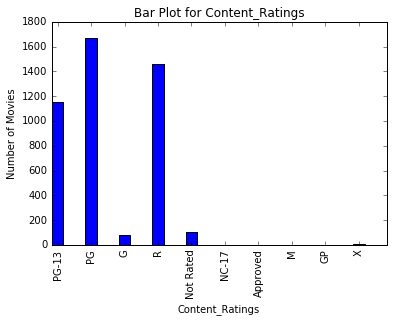

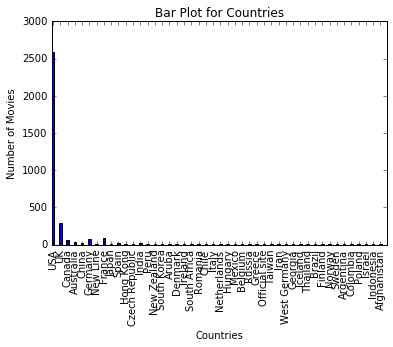

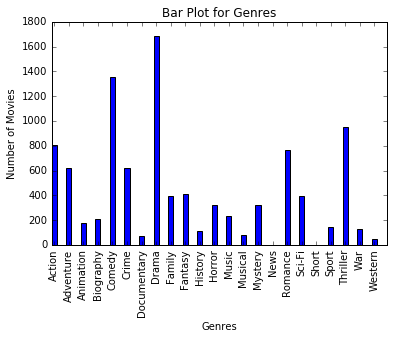

In [36]:
#Viusalization of all categorical features

#Content-rating
fig1 = plt.figure(1)
rating_sums = [movies[a].sum() for a in rating]
rating_num = len(rating_sums)
rating_range = range(rating_num)
width = 0.35
axes = plt.gca()
axes.set_xlim([0, len(rating)])
plt.bar(rating_range, rating_sums, width)
plt.xticks(np.arange(len(rating))+width*0.5,rating, rotation='vertical')
plt.title('Bar Plot for Content_Ratings')
plt.xlabel('Content_Ratings')
plt.ylabel('Number of Movies')

#Country
fig2 = plt.figure(2)
country_sums = [movies[a].sum() for a in countries]
country_num = len(country_sums)
country_range = range(country_num)
width=0.35
axes = plt.gca()
axes.set_xlim([0, len(countries)])
plt.bar(country_range,country_sums, width)
plt.xticks(np.arange(len(countries))+width*0.5,countries, rotation='vertical')
plt.title('Bar Plot for Countries')
plt.xlabel('Countries')
plt.ylabel('Number of Movies')

#Genres
fig3 = plt.figure(3)
genre_sums = [movies[a].sum() for a in genres]
genre_num = len(genre_sums)
genre_range = range(genre_num)
width=0.35
axes = plt.gca()
axes.set_xlim([0, len(genres)])
plt.bar(genre_range,genre_sums, width)
plt.xticks(np.arange(len(genres))+width*0.5,genres, rotation='vertical')
plt.title('Bar Plot for Genres')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')